In [1]:
import torch
import torchvision
from torchvision import transforms, utils, models
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from random import randint

import psycopg2,datetime,heapq

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib

import os
import shutil

from sklearn.manifold import TSNE

import seaborn as sns

import random
import ipyplot
from tqdm import tqdm
from livelossplot import PlotLosses

torch.manual_seed(4096)


def readgroup():
    #Group List
    #os.chdir('/home/jack/4_Selenium')
    with open("top.txt",encoding="utf-8") as f:
        top = f.read().split("\n")
    with open("all.txt",encoding="utf-8") as f:
        allg = f.read().split("\n")
    #print(top,allg)

    run = {}
    for x in allg:
        #print(x)
        if x in top:
            head = x[:2]
            #print(head)
        else:
            #run.append((head+"-"+x[1]+"-00",x[3:]))
            run[head+"-"+x[1]+"-00"] = x[3:]
    # for i in run:
    #     print(i)
    #print(len(run))
    return run
labels_dict = readgroup()
# labels_dict

In [ ]:
conn = psycopg2.connect(database="trademark1", user="tm_root", password="roottm_9823a", host="trueint.lu.im.ntu.edu.tw", port="5433")
cur = conn.cursor()

# 從資料庫撈出純圖片資料

In [50]:
%%time
caseno_list = []
cur.execute("SELECT trademark.caseno, trademark.doc, trademark.Trademark_Design, rcp.FileName, \
            img_content.category \
            FROM trademark  INNER JOIN  rcc ON (trademark.caseno = rcc.caseno) \
             INNER JOIN rcp ON ( trademark.caseno = rcp.caseno  ) \
             INNER JOIN text ON (trademark.caseno = text.caseno) \
             INNER JOIN img_content ON ( trademark.caseno = img_content.caseno )\
where ( text.chinese is null and text.english is null and text.japanese is null and text.symbol is null) \
        ") 
r = cur.fetchall()

CPU times: user 90.5 ms, sys: 0 ns, total: 90.5 ms
Wall time: 701 ms


In [ ]:
caseno_list += [i for i in r]
len(caseno_list)

## Store

In [52]:
data = pd.DataFrame(caseno_list, columns=['caseno', 'doc', 'design', 'filename', 'content'])
data['path'] = '/service/trademark/raw_register_data/' + data.doc+ '/' + data.filename
data.dropna(inplace=True)
data.to_csv('img_index.csv', index=False)

In [92]:
data = pd.read_csv('img_index.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120390 entries, 0 to 120389
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   caseno    120390 non-null  int64 
 1   doc       120390 non-null  object
 2   design    120390 non-null  object
 3   filename  120390 non-null  object
 4   content   120390 non-null  object
 5   path      120390 non-null  object
dtypes: int64(1), object(5)
memory usage: 5.5+ MB


In [93]:
data.head()

,caseno,doc,design,filename,content,path
0,109000216,TrademarkRegXMLB_047014,(彩色)(平面),imagesdata/egimg_109000216_1_047014.jpg,02-B-00,/service/trademark/raw_register_data/Trademark...
1,108083919,TrademarkRegXMLB_047014,(墨色)(平面),imagesdata/egimg_108083919_1_047014.jpg,12-C-00,/service/trademark/raw_register_data/Trademark...
2,108083919,TrademarkRegXMLB_047014,(墨色)(平面),imagesdata/egimg_108083919_1_047014.jpg,12-A-00,/service/trademark/raw_register_data/Trademark...
3,108054749,TrademarkRegXMLB_047014,(彩色)(平面),imagesdata/egimg_108054749_1_047014.jpg,01-G-00,/service/trademark/raw_register_data/Trademark...
4,108054749,TrademarkRegXMLB_047014,(彩色)(平面),imagesdata/egimg_108054749_1_047014.jpg,02-B-00,/service/trademark/raw_register_data/Trademark...


因為多標籤，同一個caseno會出現多次

In [94]:
print(f"有{data.caseno.value_counts().shape[0]}個unique caseno (圖片)")
# data = data[ data['design'] =='(彩色)(平面)' ]

有46086個unique caseno (圖片)


In [95]:
# data = data[(data['design'] == '(墨色)(平面)') | ( data['design'] =='(彩色)(平面)' )]
data = data[ data['design'] =='(彩色)(平面)' ].drop_duplicates(keep='first')

In [96]:
print(f"彩色平面有{data.caseno.value_counts().shape[0]}張")
print(f"total numbers of labels :{data.content.value_counts().shape[0]}")

彩色平面有13852張
total numbers of labels :97


## Multi-hot encoding

### 為了解決caseno重複問題 新增兩張表 df_path & df_labels

In [97]:
a = pd.concat([data.caseno, pd.get_dummies(data.content)], axis=1).groupby('caseno').sum()
# max(a)
df_labels = a.astype('float32')
df_labels

,01-A-00,01-B-00,01-C-00,01-D-00,01-E-00,01-F-00,01-G-00,01-H-00,02-A-00,02-B-00,...,12-D-00,12-E-00,12-F-00,12-G-00,12-H-00,13-A-00,13-B-00,13-F-00,13-L-00,14-A-00
caseno,,,,,,,,,,,,,,,,,,,,,
99000467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99001415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99001623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99005152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99007594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109071468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109071857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109072030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
df_labels.describe()

,01-A-00,01-B-00,01-C-00,01-D-00,01-E-00,01-F-00,01-G-00,01-H-00,02-A-00,02-B-00,...,12-D-00,12-E-00,12-F-00,12-G-00,12-H-00,13-A-00,13-B-00,13-F-00,13-L-00,14-A-00
count,13852.000000,13852.000000,13852.000000,13852.000000,13852.000000,13852.000000,13852.000000,13852.000000,13852.000000,13852.000000,...,13852.000000,13852.000000,13852.000000,13852.000000,13852.000000,13852.000000,13852.000000,13852.000000,13852.000000,13852.000000
mean,0.038189,0.044903,0.050751,0.016965,0.020214,0.025195,0.208923,0.063673,0.053350,0.159472,...,0.042377,0.070892,0.105111,0.127274,0.013067,0.000289,0.000217,0.000072,0.000289,0.000722
std,0.191660,0.207099,0.219496,0.129145,0.140736,0.156722,0.406554,0.244179,0.224738,0.366128,...,0.201454,0.256654,0.306708,0.333292,0.113565,0.016991,0.014715,0.008497,0.016991,0.026860
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df_path = data[['caseno', 'filename', 'path' ]].drop_duplicates().set_index('caseno')
df_path

,filename,path
caseno,,
109000216,imagesdata/egimg_109000216_1_047014.jpg,/service/trademark/raw_register_data/Trademark...
108083919,imagesdata/egimg_108083919_1_047014.jpg,/service/trademark/raw_register_data/Trademark...
108054749,imagesdata/egimg_108054749_1_047014.jpg,/service/trademark/raw_register_data/Trademark...
108075997,imagesdata/egimg_108075997_1_047014.jpg,/service/trademark/raw_register_data/Trademark...
108055192,imagesdata/egimg_108055192_1_047014.jpg,/service/trademark/raw_register_data/Trademark...
...,...,...
103043789,imagesdata/egimg_103043789_1_042006.jpg,/service/trademark/raw_register_data/Trademark...
103056690,imagesdata/egimg_103056690_1_042007.jpg,/service/trademark/raw_register_data/Trademark...
103040479,imagesdata/egimg_103040479_1_042007.jpg,/service/trademark/raw_register_data/Trademark...


## EDA

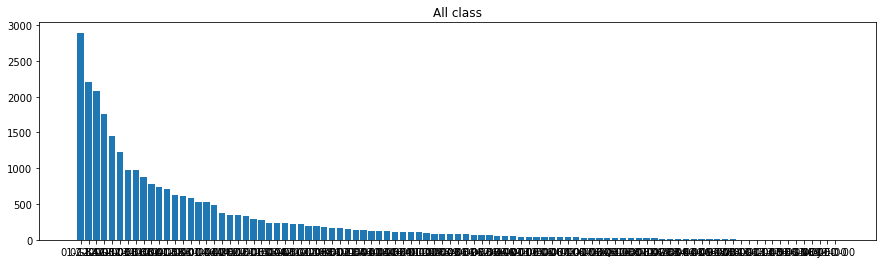

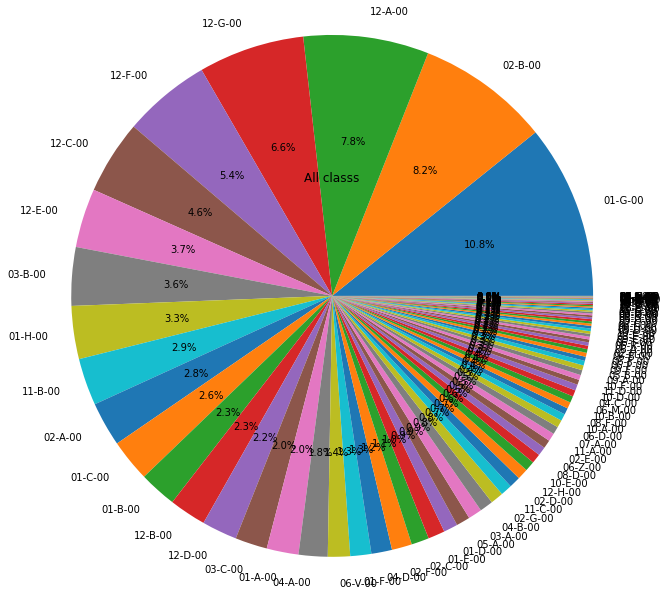

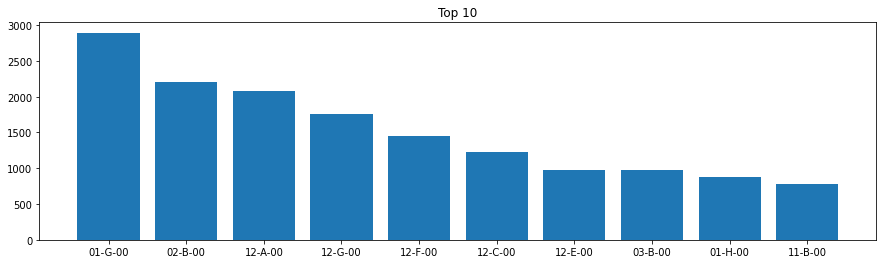

['擬人化', '走獸', '圓形外觀', '不同幾何形狀組合/重疊或其他不規則圖形(不包含線條)', '線條/曲折區塊或其與幾何圖形之組合/重疊(對稱係指整體構圖而言)', '四角形外觀', '特定形狀圖形', '花/葉/草', '人體部位', '圖形化英文']


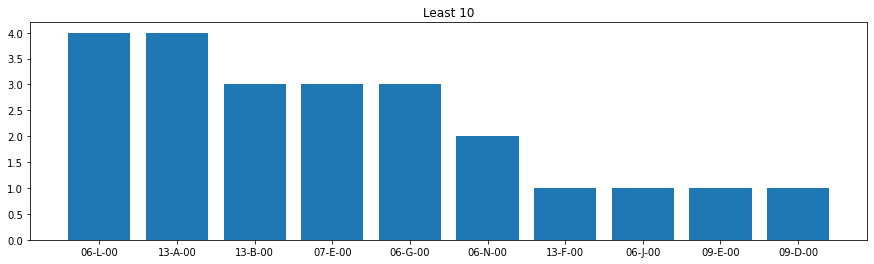

['吸煙用品(煙斗.香煙.煙灰缸.打火機)', '人物', '動物', '交通號誌', '消防設備(滅火器.消防栓.雲梯)', '理容/化妝用品(口紅.香水.刮鬍刀.牙刷.鏡子)', '器物', '衛浴設備(馬桶.浴缸.洗臉檯.水龍頭)', '水果製品(芒果乾)', '海鮮製品(烏魚子)']


In [624]:
y = df_labels.sum().sort_values(ascending=False)
x = df_labels.sum().sort_values(ascending=False).index
chinese_labels = [labels_dict[i] for i in x]
plt.figure(figsize=(15,4))
plt.bar(x, y)
plt.title("All class")
plt.show()

plt.pie(y, labels=x,radius=3,autopct='%1.1f%%')
plt.title("All classs")
plt.show()

plt.figure(figsize=(15,4))
plt.bar(x[:10], y[:10])
plt.title("Top 10")
plt.show()
print(chinese_labels[:10])


plt.figure(figsize=(15,4))
plt.bar(x[-10:], y[-10:])
plt.title("Least 10")
plt.show()
print(chinese_labels[-10:])


In [623]:
df_labels.sum(axis=1).describe()

count    13852.000000
mean         1.937915
std          0.876069
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          9.000000
dtype: float64

平均每張圖片有1.9個標籤  
最多的有9個標籤

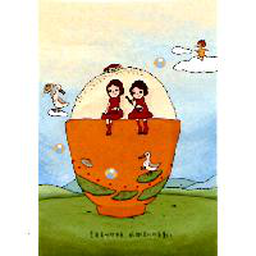

103016216
女人 ; 人物組合 ; 飛禽/蝙蝠 ; 花/葉/草 ; 自然現象 ; 景觀 ; 休閒運動用品(球.球拍.球棒.釣具.風箏.玩具.汽球.撲克牌.衝浪板；不含運動用之手足配備) ; 廚房設備/器皿(叉.盆.碗.壺.瓶.汽水瓶.鼎.尊.花瓶.杯子.杵臼) ; 帽子


In [653]:
df_labels.iloc[df_labels.sum(axis=1).argmax()].name
labels = []
for j in df_labels.columns:
    if df_labels.loc[df_labels.iloc[df_labels.sum(axis=1).argmax()].name][j] > 0:
        labels.append(j)
a = [labels_dict[i] for i in labels]
img = Image.open(df_merge.loc[df_labels.iloc[df_labels.sum(axis=1).argmax()].name].path)
img = img.resize((2*128,2*128),Image.ANTIALIAS)
display(img)
print(df_labels.iloc[df_labels.sum(axis=1).argmax()].name)
print(f"{' ; '.join(a)}")

### Show 出少數類別的圖片

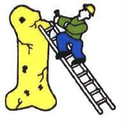

99062300
男人 ; 人體部位 ; 消防設備(滅火器.消防栓.雲梯)


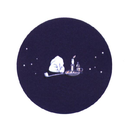

100006509
照明設備(手電筒.蠟燭.燈籠.火把.火燄.美術燈.油燈.燭台.電池) ; 吸煙用品(煙斗.香煙.煙灰缸.打火機) ; 帽子


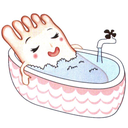

101024863
擬人化 ; 人體部位 ; 衛浴設備(馬桶.浴缸.洗臉檯.水龍頭)


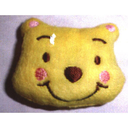

101041843
走獸 ; 動物


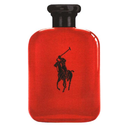

101056011
男人 ; 性別不明 ; 理容/化妝用品(口紅.香水.刮鬍刀.牙刷.鏡子)


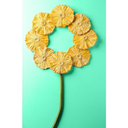

102043542
花/葉/草 ; 水果製品(芒果乾) ; 其他或組合(比薩) ; 五角形以上外觀


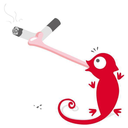

102059419
爬蟲/兩棲/其他 ; 吸煙用品(煙斗.香煙.煙灰缸.打火機)


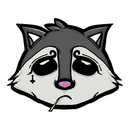

102063584
擬人化 ; 走獸 ; 吸煙用品(煙斗.香煙.煙灰缸.打火機)


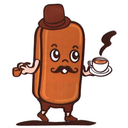

103009069
擬人化 ; 吸煙用品(煙斗.香煙.煙灰缸.打火機) ; 廚房設備/器皿(叉.盆.碗.壺.瓶.汽水瓶.鼎.尊.花瓶.杯子.杵臼) ; 帽子


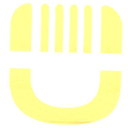

104014071
理容/化妝用品(口紅.香水.刮鬍刀.牙刷.鏡子) ; 不同幾何形狀組合/重疊或其他不規則圖形(不包含線條)


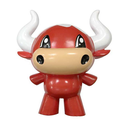

104014175
擬人化 ; 走獸 ; 人物 ; 動物


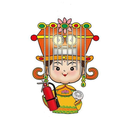

104019075
神怪 ; 消防設備(滅火器.消防栓.雲梯)


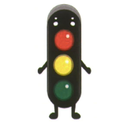

104021678
擬人化 ; 交通號誌


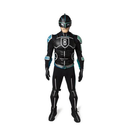

105047580
男人 ; 擬人化 ; 盾牌 ; 圖形化英文 ; 人物


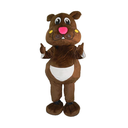

105057184
擬人化 ; 走獸 ; 人物 ; 動物


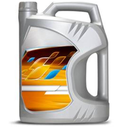

106035096
不同幾何形狀組合/重疊或其他不規則圖形(不包含線條) ; 器物


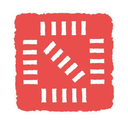

106064391
交通號誌 ; 四角形外觀


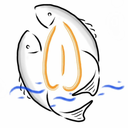

107011826
水族 ; 海鮮製品(烏魚子)


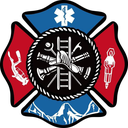

107069552
景觀 ; 機械用品(引擎.馬達.齒輪) ; 消防設備(滅火器.消防栓.雲梯) ; 帽子 ; 勳章/徽章/貨幣/獎杯/獎牌/郵票


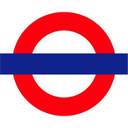

108067729
交通號誌 ; 不同幾何形狀組合/重疊或其他不規則圖形(不包含線條)


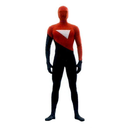

108079796
男人 ; 人物


In [660]:
least_10_class_img = df_labels[(df_labels[x[-10:]].sum(axis=1) > 0)]
for i in least_10_class_img.index:
    labels = []
    for j in df_labels.columns:
        if df_labels.loc[i][j] > 0:
            labels.append(j)
    a = [labels_dict[i] for i in labels]
    img = Image.open(df_merge.loc[i].path)
    img = img.resize((128,128),Image.ANTIALIAS)
    display(img)
    print(i)
    print(f"{' ; '.join(a)}")

In [106]:
df_labels印出各種圖片
def show_img_design(design, num=4):
    imgs = []
    a = list(data[data.design==design]['path'])
    if len(a) <= num:
        for i in a:
            img = Image.open( i )
            img = img.resize((128, 128), Image.ANTIALIAS)
            imgs.append(img)
    else:
        for i in range(num):
            img = Image.open( random.choice(a) )
            img = img.resize((128, 128), Image.ANTIALIAS)
            imgs.append(img)
    ipyplot.plot_images(imgs, max_images=num)
#     display(imgs)

In [ ]:
# imgs = []
# for i in  df_path.path:
#     img = Image.open(i)
#     img = img.resize((128, 128), Image.ANTIALIAS)
#     imgs.append(img)
# ipyplot.plot_images(imgs, max_images=1000)

In [109]:
df_labels.to_csv('labels.csv', index=True)
df_path.to_csv('path.csv', index=True)

In [6]:
df_labels = pd.read_csv('labels.csv',index_col='caseno')
df_path = pd.read_csv('path.csv',index_col='caseno')
# df_path

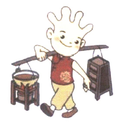

101051647
小孩/嬰兒 ; 擬人化 ; 廚房設備/器皿(叉.盆.碗.壺.瓶.汽水瓶.鼎.尊.花瓶.杯子.杵臼)


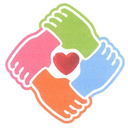

109026975
人體部位 ; 特定形狀圖形


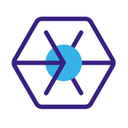

107081984
箭號或三角形外觀 ; 五角形以上外觀


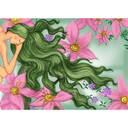

103004977
女人 ; 花/葉/草


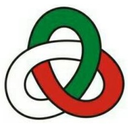

105035798
箭號或三角形外觀


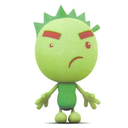

103030374
擬人化 ; 根莖果蔬類


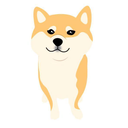

107003471
走獸


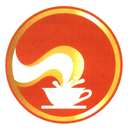

100009782
廚房設備/器皿(叉.盆.碗.壺.瓶.汽水瓶.鼎.尊.花瓶.杯子.杵臼) ; 圓形外觀


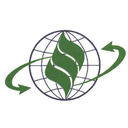

102004289
天體 ; 箭號或三角形外觀 ; 線條/曲折區塊或其與幾何圖形之組合/重疊(對稱係指整體構圖而言)


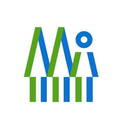

105078099
人體部位 ; 樹 ; 住屋


In [114]:
for i in df_labels.sample(10).index:
    labels = []
    for j in df_labels.columns:
        if df_labels.loc[i][j] > 0:
            labels.append(j)
    a = [labels_dict[i] for i in labels]
    img = Image.open(df_merge.loc[i].path)
    img = img.resize((128,128),Image.ANTIALIAS)
    display(img)
    print(i)
    print(f"{' ; '.join(a)}")

## Load image

In [2]:
df_labels = pd.read_csv('labels.csv',index_col='caseno')
df_path = pd.read_csv('path.csv',index_col='caseno')
# df_path
df_merge = pd.concat([df_path, df_labels], axis=1)
df_merge

,filename,path,01-A-00,01-B-00,01-C-00,01-D-00,01-E-00,01-F-00,01-G-00,01-H-00,...,12-D-00,12-E-00,12-F-00,12-G-00,12-H-00,13-A-00,13-B-00,13-F-00,13-L-00,14-A-00
caseno,,,,,,,,,,,,,,,,,,,,,
99000467,imagesdata/egimg_099000467_1_041001.jpg,/service/trademark/raw_register_data/Trademark...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99001415,imagesdata/egimg_099001415_1_039024.jpg,/service/trademark/raw_register_data/Trademark...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99001623,imagesdata/egimg_099001623_1_039003.jpg,/service/trademark/raw_register_data/Trademark...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99005152,imagesdata/egimg_099005152_1_038022.jpg,/service/trademark/raw_register_data/Trademark...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99007594,imagesdata/egimg_099007594_1_038020.jpg,/service/trademark/raw_register_data/Trademark...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109071468,imagesdata/egimg_109071468_1_048005.jpg,/service/trademark/raw_register_data/Trademark...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109071857,imagesdata/egimg_109071857_1_048005.jpg,/service/trademark/raw_register_data/Trademark...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109072030,imagesdata/egimg_109072030_1_048005.jpg,/service/trademark/raw_register_data/Trademark...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
a = df_merge[np.logical_and(df_merge.index > 108011071, df_merge.index < 108011081)]
# a = a.drop(columns=['filename','path'])
for i in range(5):
    print(a.drop_duplicates().path.iloc[i])

/service/trademark/raw_register_data/TrademarkRegXMLB_046015/imagesdata/egimg_108011072_1_046015.jpg
/service/trademark/raw_register_data/TrademarkRegXMLB_046015/imagesdata/egimg_108011073_1_046015.jpg
/service/trademark/raw_register_data/TrademarkRegXMLB_046015/imagesdata/egimg_108011074_1_046015.jpg
/service/trademark/raw_register_data/TrademarkRegXMLB_046015/imagesdata/egimg_108011075_1_046015.jpg
/service/trademark/raw_register_data/TrademarkRegXMLB_046015/imagesdata/egimg_108011076_1_046015.jpg


In [4]:
class train_set(Dataset):
    def __init__(self, df_labels, df_path, transform):
        self.df_merge = pd.concat([df_path, df_labels], axis=1)
        self.df_merge = self.df_merge[:int(self.df_merge.shape[0]*0.8)]
        self.transform = transform
        self.labels = self.df_merge.drop(columns=['filename', 'path']).values
        self.labels = self.labels.astype('float32')
        self.path = self.df_merge[['path']].values
    
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        image = Image.open(self.path[idx][0]).convert('RGB')
        label = self.labels[idx]
        image = self.transform(image)
        return image, label

class test_set(Dataset):
    def __init__(self, df_labels, df_path, transform):
        self.df_merge = pd.concat([df_path, df_labels], axis=1)
        self.df_merge = self.df_merge[int(self.df_merge.shape[0]*0.8):]
        self.transform = transform
        self.labels = self.df_merge.drop(columns=['filename', 'path']).values
        self.labels = self.labels.astype('float32')
        self.path = self.df_merge[['path']].values
        self.label_code = self.df_merge.drop(columns=['filename', 'path']).columns
    
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        image = Image.open(self.path[idx][0]).convert('RGB')
        label = self.labels[idx]
        image = self.transform(image)
        
        return image, label
    


In [9]:
train_data = train_set(df_labels, df_path, transform=transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    
    
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=(0, 5), contrast=(0, 5), saturation=(0, 5), hue=(-0.1, 0.1)),
    
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))

test_data = test_set(df_labels, df_path, transform=transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))

In [10]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16,shuffle=True,num_workers=6,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False)
print(len(train_loader))
print(len(test_loader))

693
2771


In [11]:
df_labels.values.dtype

dtype('float64')

In [12]:
# # Display image and label.
# train_features, train_labels = next(iter(train_loader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].squeeze().numpy()
# img = np.transpose(img, (1, 2, 0))
# labels = []
# for i, j in enumerate(train_labels[0]):
#     if j > 0:
#         labels.append(df_labels.columns[i])
# label = [labels_dict[i] for i in labels]
# plt.imshow(img)
# plt.show()
# print(f"Label: {' ; '.join(label)}")

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def my_model(model, requires_grad=True):
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    num_ftrs = model.fc.in_features 
    model.fc = torch.nn.Linear(num_ftrs, len(df_labels.columns))
    return model


In [14]:

# model = models.resnet152(pretrained=True)
model = my_model(models.resnet152(pretrained=True), requires_grad=True)

# for param in model.parameters():
#     param.requires_grad = False
# num_ftrs = model.fc.in_features 
# model.fc = torch.nn.Linear(num_ftrs, len(df_labels.columns))


model = model.to(device)


# [Multilabel classification 要用 binary cross entropy](https://wenwender.wordpress.com/2019/09/20/multi-label%E8%99%95%E7%90%86/)
BCE < 0  overflow ?

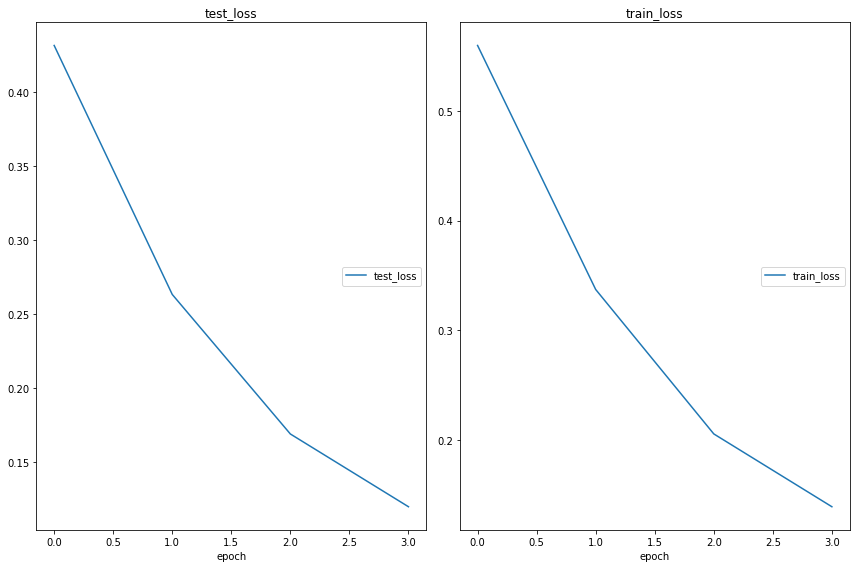

  0%|          | 0/693 [00:00<?, ?it/s]

test_loss
	test_loss        	 (min:    0.120, max:    0.431, cur:    0.120)
train_loss
	train_loss       	 (min:    0.139, max:    0.560, cur:    0.139)
epoch : 4


 62%|██████▏   | 1710/2771 [00:47<00:30, 35.22it/s]

In [ ]:
%%time
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)


num_epochs = 10
liveloss = PlotLosses()

# Train
for epoch in range(num_epochs):
    print("epoch :", epoch)
    logs = {}
    running_loss = 0.0
#     train_accs = []
#     test_accs = []
    test_loss = []
    model.train()
    for times, data in enumerate(tqdm(train_loader)):
        model.train()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
#         acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()
#         train_accs.append(acc)
        loss = criterion(outputs, labels)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        

    logs['train_loss'] = running_loss/times
#     logs['train_accracy'] = sum(train_accs) / len(train_accs)
    with torch.no_grad():
        for data in tqdm(test_loader):
            model.eval()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)
            
            test_loss.append(loss.detach().item())
#             acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()
#             test_accs.append(acc)

    logs['test_loss'] = sum(test_loss) / len(test_loss)
#     logs['test_accuracy'] = sum(test_accs) / len(test_accs)
    liveloss.update(logs)
    liveloss.send()
print('Finished Training')

In [13]:

torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

In [16]:
PATH = "model.pt"
checkpoint = torch.load(PATH)
model = my_model(models.resnet152(pretrained=True), requires_grad=True)
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, len(df_labels.columns))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

In [ ]:
threshold = 0.5
title = []
imgs = []
with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader)):
        model.eval()
        if i % 20 == 1:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs).cpu()
            outputs = outputs.numpy()
            labels = test_loader.dataset.label_code[(outputs[0])>threshold].tolist()
            if len(labels) == 0:
                labels = [ test_loader.dataset.label_code[np.argmax(outputs[0])]]
            img = Image.open(test_loader.dataset.path[i][0])
            caseno = test_loader.dataset.df_merge.index[i]
            img = img.resize((128,128),Image.ANTIALIAS)
    #             display(img)
            label = [labels_dict[i] for i in labels]
    #             img = inputs.cpu().squeeze().numpy()
    #             img = np.transpose(img, (1, 2, 0))
    #             plt.imshow((img))
    #             plt.show()

    #             print(f"pred labels : {' ; '.join(label)}")
            gd = test_loader.dataset.label_code[test_loader.dataset.labels[i]>0]
    #             print(f"ground truth: {' ; '.join([labels_dict[i] for i in gd])}")

            title.append("caseno: {}\nPred Labels : {}\nGround Truth: {}".format(caseno, ' ; '.join(label), ' ; '.join([labels_dict[i] for i in gd])))
            imgs.append(img)
ipyplot.plot_class_representations(imgs, title, img_width=200)

## 觀察
108011071~108011091
長得像老虎的都是台中畫博吉祥物圖片都是一樣的，只是產業類別不一樣而已
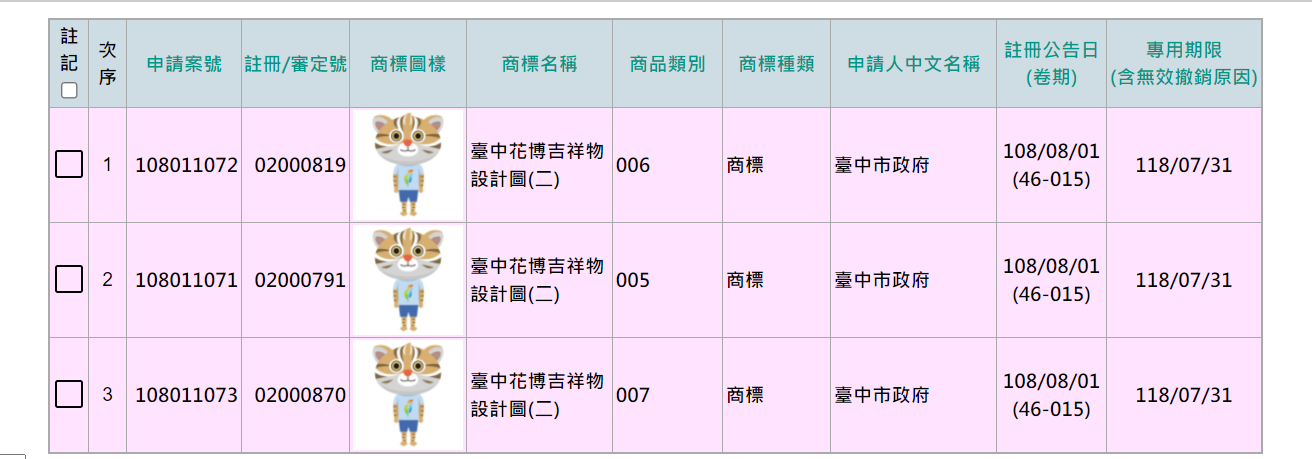

# Evaluation
## [threshold ? 論文：Multi-label Classification: A Comparative Study on Threshold Selection Methods](http://dmip.webs.upv.es/LMCE2014/Papers/lmce2014_submission_11.pdf  )
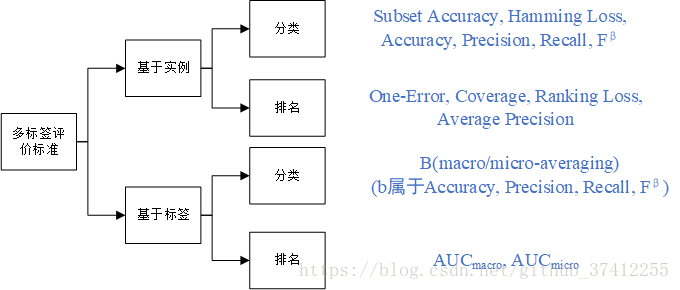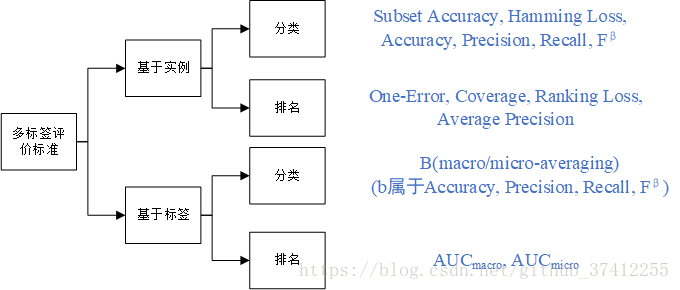

In [12]:
threshold = 0.5
y_pred = []
y_true = []
top1_y_acc = []
top3_y_acc = []
top5_y_acc = []
with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader)):
        model.eval()
        if True:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)[0]
            
            outputs = torch.sigmoid(outputs).cpu()
            outputs = outputs.numpy()
            
            # binary
            binary_output = (outputs > threshold).astype(int)
            if 1 not in binary_output:
                binary_output[np.argmax(outputs)] = 1
            y_pred.append(binary_output)
            
            #top 1
            top1_index = np.argsort(outputs)[-1:][::-1]
            hit = False
            for index in top1_index:
                if (test_loader.dataset.labels[i]>0).astype(int)[index] > 0:
                    hit = True
            if hit is True:
                top1_y_acc.append(1)
            else:
                top1_y_acc.append(0)
                
            # top 3
            top3_index = np.argsort(outputs)[-3:][::-1]
            hit = False
            for index in top3_index:
                if (test_loader.dataset.labels[i]>0).astype(int)[index] > 0:
                    hit = True
            if hit is True:
                top3_y_acc.append(1)
            else:
                top3_y_acc.append(0)
#             print(outputs)
#             print(np.argsort(outputs)[-3:][::-1])
#             print(max(outputs))
#             print(np.argmax(outputs))
    
            # top 5
            top5_index = np.argsort(outputs)[-5:][::-1]
            hit = False
            for index in top5_index:
                if (test_loader.dataset.labels[i]>0).astype(int)[index] > 0:
                    hit = True
            if hit is True:
                top5_y_acc.append(1)
            else:
                top5_y_acc.append(0)
    
            y_true.append((test_loader.dataset.labels[i]>0).astype(int))


100%|██████████| 2771/2771 [01:16<00:00, 36.19it/s]


In [13]:
y_pred = np.stack(y_pred, axis=0)
y_true = np.stack(y_true, axis=0)


In [14]:
# def Hamming_Loss(y_true, y_pred):
#     temp=0
#     for i in range(y_true.shape[0]):
#         temp += np.size(y_true[i] == y_pred[i]) - np.count_nonzero(y_true[i] == y_pred[i])
#     return temp/(y_true.shape[0] * y_true.shape[1])
# def Accuracy(y_true, y_pred):
#     temp = 0
#     for i in range(y_true.shape[0]):
#         temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
#     return temp / y_true.shape[0]
# def Precision(y_true, y_pred):
#     temp = 0
#     for i in range(y_true.shape[0]):
#         if sum(y_true[i]) == 0:
#             continue
#         temp += sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_true[i])
#     return temp/ y_true.shape[0]
# def Recall(y_true, y_pred):
#     temp = 0
#     for i in range(y_true.shape[0]):
#         if sum(y_pred[i]) == 0:
#             continue
#         temp += sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_pred[i])
#     return temp/ y_true.shape[0]

# def F1Measure(y_true, y_pred):
#     temp = 0
#     for i in range(y_true.shape[0]):
#         if (sum(y_true[i]) == 0) and (sum(y_pred[i]) == 0):
#             continue
#         temp+= (2*sum(np.logical_and(y_true[i], y_pred[i])))/ (sum(y_true[i])+sum(y_pred[i]))
#     return temp/ y_true.shape[0]

# def evaluation(y_true, y_pred):
#     print(f"Hamming loss :{Hamming_Loss(y_true, y_pred)}")
#     print(f"Accuracy     :{Accuracy(y_true, y_pred)}")
#     print(f"Precision    :{Precision(y_true, y_pred)}")
#     print(f"Recall       :{Recall(y_true, y_pred)}")
#     print(f"F1Measure    :{F1Measure(y_true, y_pred)}")
    
# evaluation(y_true, y_pred)

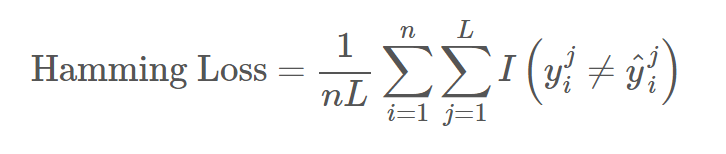   
被錯誤分類的比例，約小越好

圖片平均label數  
去掉較少的label & 合併class  

macro & micro average

定義答對: e.g. 兩個label猜到一個
precision & recall 有問題

top 3 : 前三個有碰到正確label就好

每一個 class 都算一個 threshold  maximize f1

試試看新增17大類的label

accuracy 計算有問題 應該會比較大

### TOP-N Accuracy
前 N 個機率最大的output 中包含到任意一個 ground truth 即視為預測正確

In [15]:
def topN():
    print("top 1: {:.3f}".format(sum(top1_y_acc)/len(top1_y_acc)))
    print("top 3: {:.3f}".format(sum(top3_y_acc)/len(top3_y_acc)))
    print("top 5: {:.3f}".format(sum(top5_y_acc)/len(top5_y_acc)))
topN()

top 1: 0.562
top 3: 0.778
top 5: 0.850


## Confusion Matrix

In [16]:
tp = []
tn = []
fp = []
fn = []
for i in range(y_pred.shape[1]):
    pred = y_pred[:,i]
    true = y_true[:,i]

    tp.append(np.logical_and(pred, true).sum())
    
    fp.append(pred.sum()-np.logical_and(pred, true).sum())

    tn.append((pred==true).sum()-np.logical_and(pred, true).sum())


    cnt = 0
    for m, n in zip(y_pred[:,i], y_true[:,i]):
        if m==0 and n==1:
            cnt += 1
    fn.append(cnt)
tp = np.array(tp)
fp = np.array(fp)
tn = np.array(tn)
fn = np.array(fn)

## Macro-average

In [17]:
def macro():
    accuracy = ((tp+tn)/(tp+fp+tn+fn))
    print("Accuracy : {:.3f}".format(accuracy.mean()))
    recall = tp/(tp+fn)
    print("Recall   : {:.3f}".format(   recall[~np.isnan(recall)].mean()    ))
    precision = tp/(tp+fp)
    print("Precision: {:.3f}".format(   precision[~np.isnan(precision)].mean()    ))

macro()

Accuracy : 0.983
Recall   : 0.097
Precision: 0.501


<ipython-input-17-19f333be2588>:4: RuntimeWarning: invalid value encountered in true_divide
  recall = tp/(tp+fn)
<ipython-input-17-19f333be2588>:6: RuntimeWarning: invalid value encountered in true_divide
  precision = tp/(tp+fp)


## Micro-average

In [18]:
def micro():
    print("Recall   : {:.3f}".format(   tp.sum()/(tp.sum() + fn.sum())  ))
    print("Precision: {:.3f}".format(   tp.sum()/(tp.sum() + fp.sum())  ))
micro()

Recall   : 0.380
Precision: 0.576


## Weighted-average
根據各個 class 佔總postive數量的比例去加權  (比如人類這個類別有 100筆， 非人類的類別有 2000筆， 人類的權重為 100/2000)

In [19]:
def weighted():
    weights = y_true.sum(axis=0)/y_true.sum()
    accuracy = ((tp+tn)/(tp+fp+tn+fn))
    print("Accuracy : {:.3f}".format(  np.dot(accuracy, weights)))
    recall = tp/(tp+fn)
    print("Recall : {:.3f}".format(  np.dot(recall[~np.isnan(recall)], weights[~np.isnan(recall)])   ))
    
    precision = tp/(tp+fp)
    print("Precision : {:.3f}".format(  np.dot(precision[~np.isnan(precision)], weights[~np.isnan(precision)])   ))
weighted()

Accuracy : 0.930
Recall : 0.380
Precision : 0.483


<ipython-input-19-92ac9893388d>:5: RuntimeWarning: invalid value encountered in true_divide
  recall = tp/(tp+fn)
<ipython-input-19-92ac9893388d>:8: RuntimeWarning: invalid value encountered in true_divide
  precision = tp/(tp+fp)


## Summary

In [20]:
def summary():
    print("-----top N------")
    topN()
    print("-----Macro-----")
    macro()
    print("-----Micro-----")
    micro()
    print("-----Weighted-----")
    weighted()
summary()

-----top N------
top 1: 0.562
top 3: 0.778
top 5: 0.850
-----Macro-----
Accuracy : 0.983
Recall   : 0.097
Precision: 0.501
-----Micro-----
Recall   : 0.380
Precision: 0.576
-----Weighted-----
Accuracy : 0.930
Recall : 0.380
Precision : 0.483


<ipython-input-17-19f333be2588>:4: RuntimeWarning: invalid value encountered in true_divide
  recall = tp/(tp+fn)
<ipython-input-17-19f333be2588>:6: RuntimeWarning: invalid value encountered in true_divide
  precision = tp/(tp+fp)
<ipython-input-19-92ac9893388d>:5: RuntimeWarning: invalid value encountered in true_divide
  recall = tp/(tp+fn)
<ipython-input-19-92ac9893388d>:8: RuntimeWarning: invalid value encountered in true_divide
  precision = tp/(tp+fp)


## 問題
* 目前的資料過濾掉圖中有文字的彩色平面部分
* 重複的圖片要怎麼辦

計算column wise 的 presion & recall 

NDCG

篩掉重複圖片:  
pretrain model 倒數第二層  
cosine similarity (L2) 設threshold 去篩